In [6]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
!kaggle datasets download karagwaanntreasure/plant-disease-detection

Dataset URL: https://www.kaggle.com/datasets/karagwaanntreasure/plant-disease-detection
License(s): MIT
100% 532M/534M [00:01<00:00, 323MB/s]
100% 534M/534M [00:01<00:00, 425MB/s]


In [9]:
import zipfile
zip=zipfile.ZipFile('/content/plant-disease-detection.zip','r')
zip.extractall()
zip.close()

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import keras
import tensorflow

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121,ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np


In [14]:
train_data=keras.utils.image_dataset_from_directory(
    directory='/content/Dataset',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(160,160),
    subset='training',
    validation_split=0.2,
    seed=123,
    shuffle=True
)
validation_data=keras.utils.image_dataset_from_directory(
    directory='/content/Dataset',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(160,160),
    subset='validation',
    validation_split=0.2,
    seed=123,
    shuffle=True
)

Found 35725 files belonging to 23 classes.
Using 28580 files for training.
Found 35725 files belonging to 23 classes.
Using 7145 files for validation.


In [18]:
net=ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(160,160,3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
net.trainable=False

In [20]:
net.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [33]:
model=models.Sequential([
    net,
    layers.GlobalAveragePooling2D(),
    Dense(128,activation='relu'),
    Dense(23,activation='softmax')
])

In [35]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [30]:
earlystopping=EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True


)
modelcheck=ModelCheckpoint(
    'plant_disease.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True

)

In [36]:

model.fit(train_data,validation_data=validation_data,epochs=20,callbacks=[earlystopping,modelcheck])

Epoch 1/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8055 - loss: 0.6687
Epoch 1: val_accuracy improved from -inf to 0.92960, saving model to plant_disease.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.8056 - loss: 0.6684 - val_accuracy: 0.9296 - val_loss: 0.2085
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9451 - loss: 0.1639
Epoch 2: val_accuracy improved from 0.92960 to 0.93842, saving model to plant_disease.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - accuracy: 0.9451 - loss: 0.1639 - val_accuracy: 0.9384 - val_loss: 0.1808
Epoch 3/20


KeyboardInterrupt: 

In [37]:
model.predict(validation_data)

224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step


array([[7.28218538e-07, 1.28168369e-06, 2.46780047e-07, ...,
        1.83169232e-05, 4.21040386e-05, 3.34599304e-06],
       [8.22750437e-08, 4.50140725e-09, 9.99998212e-01, ...,
        3.22647242e-10, 2.12257902e-12, 6.84676621e-12],
       [2.90453387e-03, 2.23422944e-06, 2.62457647e-08, ...,
        2.39780112e-10, 1.32377997e-10, 1.79541146e-03],
       ...,
       [4.11165324e-09, 2.43884253e-11, 6.21438179e-11, ...,
        2.85078666e-17, 4.99337410e-16, 4.03837033e-12],
       [1.00000000e+00, 3.31485417e-08, 4.83502995e-12, ...,
        5.46414602e-15, 5.24730095e-17, 9.03863013e-15],
       [2.20085261e-09, 1.41937970e-12, 4.96776977e-07, ...,
        4.22142564e-11, 1.13258415e-13, 1.38002075e-11]], dtype=float32)

In [38]:
loss,accuracy=model.evaluate(validation_data)

224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9385 - loss: 0.1804


In [39]:
print(loss,accuracy)

0.18077462911605835 0.938418447971344


# Therefore the **accuracy** is 93.8


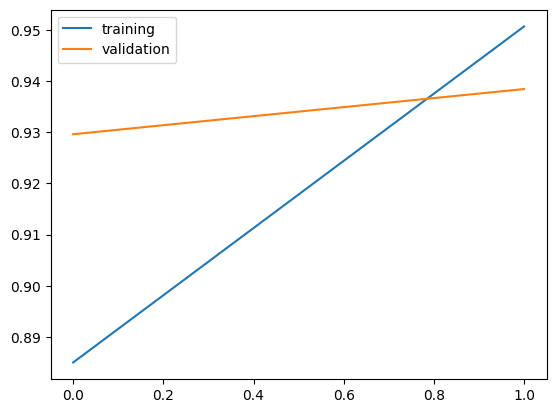

In [41]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'],label='training')
plt.plot(model.history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

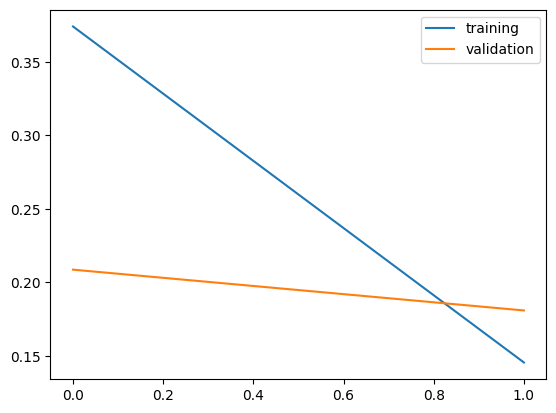

In [43]:
plt.plot(model.history.history['loss'],label='training')
plt.plot(model.history.history['val_loss'],label='validation')
plt.legend()
plt.show()